# Decision Tree Classification - Heart Disease Prediction

## Overview
A **Decision Tree** is a supervised learning algorithm that makes predictions by learning simple decision rules from data features. It recursively splits the dataset into subsets based on feature values to minimize impurity (Gini Index or Information Gain).

## How Decision Trees Work

### 1. **Tree Structure**
- **Root Node**: Contains entire dataset, first split
- **Internal Nodes**: Decision points based on feature thresholds
- **Leaf Nodes**: Final predictions (class labels)
- **Edges**: Feature conditions (e.g., Age > 50)

### 2. **Splitting Criterion**
Decision trees use two main impurity measures:

**Gini Index** (used in CART - Classification And Regression Trees):
$$\text{Gini} = 1 - \sum_{i=1}^{C} p_i^2$$

Where $p_i$ is the probability of class $i$.

**Information Gain** (used in ID3, C4.5):
$$\text{Entropy} = -\sum_{i=1}^{C} p_i \log_2(p_i)$$
$$\text{Information Gain} = \text{Entropy(parent)} - \sum \text{Entropy(children)}$$

### 3. **Algorithm Process**
1. Start with all samples at root node
2. For each feature, calculate the best split that reduces impurity
3. Choose feature and threshold with maximum information gain
4. Recursively repeat for each subset until stopping criteria
5. Make predictions by following the tree path to leaf nodes

### 4. **Advantages**
✓ Interpretable and easy to visualize
✓ Handles both categorical and continuous features
✓ No feature scaling required
✓ Handles non-linear relationships
✓ Can reveal feature importance

### 5. **Disadvantages**
✗ Prone to overfitting (deep trees)
✗ Sensitive to small data changes
✗ Biased toward features with many values
✗ Requires pruning for better generalization

### 6. **Key Hyperparameters**
- `max_depth`: Maximum tree depth (controls overfitting)
- `min_samples_split`: Minimum samples to split a node
- `min_samples_leaf`: Minimum samples in leaf nodes
- `criterion`: 'gini' or 'entropy'
- `splitter`: 'best' or 'random' for feature selection

## Application to Heart Disease Prediction
We'll build a decision tree to predict heart disease by learning decision rules from clinical features like Age, Blood Pressure, Cholesterol, MaxHR, etc.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {pd.__version__}")

✓ Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.2.3
Scikit-learn version: 2.2.3


In [2]:
# Load Dataset
print("="*70)
print("LOADING DATASET")
print("="*70)

df = pd.read_csv('heart.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nTarget Variable Distribution:")
print(df['HeartDisease'].value_counts())
print(f"\nTarget Distribution (%):")
print(df['HeartDisease'].value_counts(normalize=True) * 100)

LOADING DATASET

Dataset Shape: (918, 12)
Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

First few rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up   

In [3]:
# Data Preprocessing
print("="*70)
print("DATA PREPROCESSING")
print("="*70)

# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical Columns: {categorical_cols}")
print(f"Numerical Columns: {numerical_cols}")

# Encode categorical variables
print("\nEncoding categorical variables...")
le_dict = {}
X_processed = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X[col])
    le_dict[col] = le
    print(f"  {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nProcessed Features Shape: {X_processed.shape}")
print(f"Target Shape: {y.shape}")
print(f"\nFeature names: {list(X_processed.columns)}")

DATA PREPROCESSING

Categorical Columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical Columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Encoding categorical variables...
  Sex: {'F': 0, 'M': 1}
  ChestPainType: {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
  RestingECG: {'LVH': 0, 'Normal': 1, 'ST': 2}
  ExerciseAngina: {'N': 0, 'Y': 1}
  ST_Slope: {'Down': 0, 'Flat': 1, 'Up': 2}

Processed Features Shape: (918, 11)
Target Shape: (918,)

Feature names: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


In [4]:
# Train-Test Split
print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set Size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test Set Size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")

print(f"\nTraining Set Class Distribution:")
print(y_train.value_counts())
print(f"\nTest Set Class Distribution:")
print(y_test.value_counts())

print("\n✓ Data preprocessing completed!")

TRAIN-TEST SPLIT

Training Set Size: 734 samples (80.0%)
Test Set Size: 184 samples (20.0%)

Training Set Class Distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64

Test Set Class Distribution:
HeartDisease
1    102
0     82
Name: count, dtype: int64

✓ Data preprocessing completed!


## Model Training & Optimization

### Finding Optimal Max Depth

We'll use GridSearchCV to find the best `max_depth` parameter that minimizes overfitting while maintaining good accuracy.

In [5]:
# Hyperparameter Tuning - Find Optimal Max Depth
print("="*70)
print("HYPERPARAMETER TUNING - MAX DEPTH OPTIMIZATION")
print("="*70)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Get best model
best_dt = grid_search.best_estimator_
print(f"\nBest Model Details:")
print(f"  Criterion: {best_dt.criterion}")
print(f"  Max Depth: {best_dt.max_depth}")
print(f"  Min Samples Split: {best_dt.min_samples_split}")
print(f"  Min Samples Leaf: {best_dt.min_samples_leaf}")

HYPERPARAMETER TUNING - MAX DEPTH OPTIMIZATION

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.8365

Best Model Details:
  Criterion: gini
  Max Depth: 3
  Min Samples Split: 2
  Min Samples Leaf: 1


ANALYZING MAX DEPTH IMPACT ON OVERFITTING
Depth  3: Train=0.8542, Test=0.8207, CV=0.8365
Depth  5: Train=0.8910, Test=0.8043, CV=0.8174
Depth  7: Train=0.9373, Test=0.8043, CV=0.8078
Depth 10: Train=0.9578, Test=0.7880, CV=0.7888
Depth 15: Train=0.9632, Test=0.7935, CV=0.7928
Depth 20: Train=0.9632, Test=0.7935, CV=0.7928


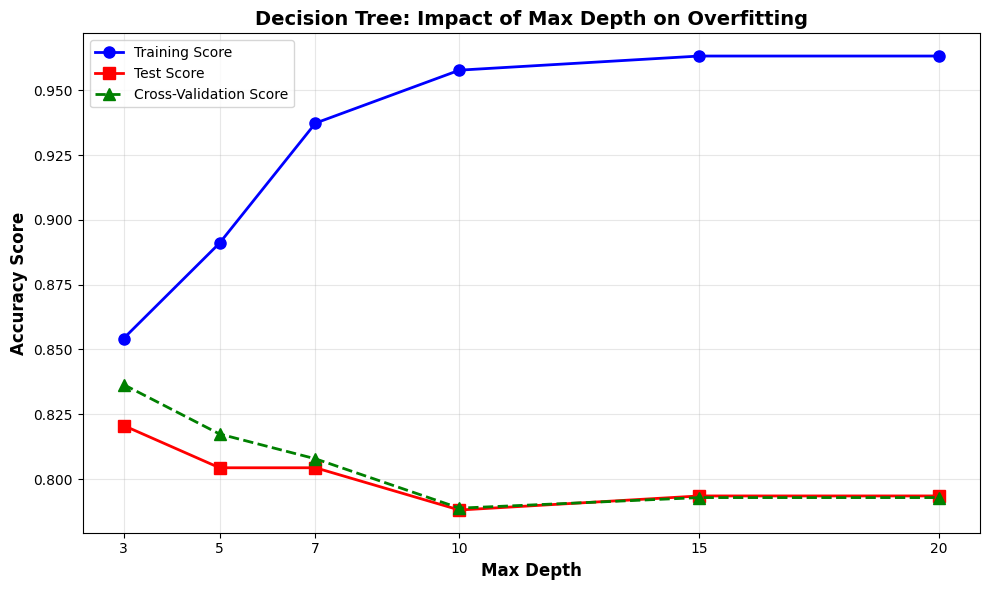


✓ Optimal depth analysis completed!


In [6]:
# Analyze Max Depth Impact
print("="*70)
print("ANALYZING MAX DEPTH IMPACT ON OVERFITTING")
print("="*70)

depths = [3, 5, 7, 10, 15, 20]
train_scores = []
test_scores = []
cv_scores_list = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=5,
        min_samples_leaf=2,
        criterion='gini',
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    
    train_score = dt_temp.score(X_train, y_train)
    test_score = dt_temp.score(X_test, y_test)
    cv_score = cross_val_score(dt_temp, X_train, y_train, cv=5).mean()
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    cv_scores_list.append(cv_score)
    
    print(f"Depth {depth:2d}: Train={train_score:.4f}, Test={test_score:.4f}, CV={cv_score:.4f}")

# Visualize the relationship
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depths, train_scores, 'bo-', label='Training Score', linewidth=2, markersize=8)
ax.plot(depths, test_scores, 'rs-', label='Test Score', linewidth=2, markersize=8)
ax.plot(depths, cv_scores_list, 'g^--', label='Cross-Validation Score', linewidth=2, markersize=8)
ax.set_xlabel('Max Depth', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax.set_title('Decision Tree: Impact of Max Depth on Overfitting', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xticks(depths)
plt.tight_layout()
plt.show()

print("\n✓ Optimal depth analysis completed!")

In [7]:
# Train Final Decision Tree Model
print("="*70)
print("TRAINING FINAL DECISION TREE MODEL")
print("="*70)

# Use optimized hyperparameters from GridSearchCV
final_dt = DecisionTreeClassifier(
    max_depth=best_dt.max_depth,
    min_samples_split=best_dt.min_samples_split,
    min_samples_leaf=best_dt.min_samples_leaf,
    criterion=best_dt.criterion,
    random_state=42
)

final_dt.fit(X_train, y_train)

# Training accuracy
train_pred = final_dt.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Tree Depth: {final_dt.get_depth()}")
print(f"Number of Leaves: {final_dt.get_n_leaves()}")
print(f"Number of Features Used: {final_dt.n_features_in_}")

print("\n✓ Model training completed!")

TRAINING FINAL DECISION TREE MODEL

Training Accuracy: 0.8542
Tree Depth: 3
Number of Leaves: 8
Number of Features Used: 11

✓ Model training completed!


## Model Evaluation & Metrics

In [8]:
# Predictions & Evaluation Metrics
print("="*70)
print("PREDICTIONS & EVALUATION METRICS")
print("="*70)

# Make predictions
y_pred = final_dt.predict(X_test)
y_pred_proba = final_dt.predict_proba(X_test)

# Calculate metrics
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"\n{'Metric':<20} {'Score':<15} {'Interpretation'}")
print("-" * 60)
print(f"{'Accuracy':<20} {test_acc:<15.4f} Overall correctness")
print(f"{'Precision':<20} {test_prec:<15.4f} True positives / All positives")
print(f"{'Recall':<20} {test_recall:<15.4f} Detected diseases / All diseases")
print(f"{'F1-Score':<20} {test_f1:<15.4f} Harmonic mean of Precision & Recall")
print(f"{'ROC-AUC':<20} {roc_auc:<15.4f} Discrimination ability")

# Cross-validation score
cv_scores = cross_val_score(final_dt, X_train, y_train, cv=5)
print(f"\nCross-Validation Scores (5-fold): {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted Normal  Predicted Disease")
print(f"Actually Normal  {cm[0,0]:>15d}  {cm[0,1]:>18d}")
print(f"Actually Disease {cm[1,0]:>15d}  {cm[1,1]:>18d}")

PREDICTIONS & EVALUATION METRICS

Metric               Score           Interpretation
------------------------------------------------------------
Accuracy             0.8207          Overall correctness
Precision            0.8710          True positives / All positives
Recall               0.7941          Detected diseases / All diseases
F1-Score             0.8308          Harmonic mean of Precision & Recall
ROC-AUC              0.8859          Discrimination ability

Cross-Validation Scores (5-fold): [0.88435374 0.84353741 0.8707483  0.78911565 0.79452055]
Mean CV Score: 0.8365 ± 0.0388

Confusion Matrix:
                 Predicted Normal  Predicted Disease
Actually Normal               70                  12
Actually Disease              21                  81


In [9]:
# Classification Report
print("="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)

report = classification_report(y_test, y_pred, target_names=['Normal', 'Disease'])
print(f"\n{report}")

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Normal       0.77      0.85      0.81        82
     Disease       0.87      0.79      0.83       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.82      0.82       184



CONFUSION MATRIX VISUALIZATION


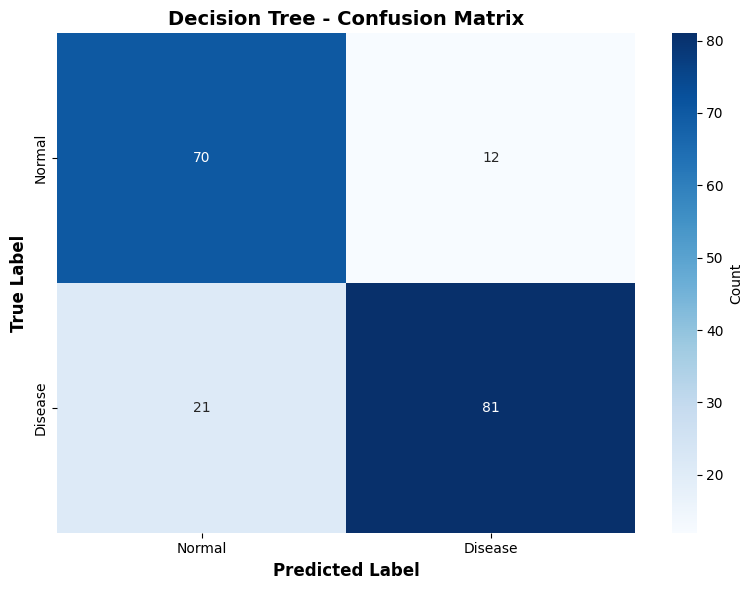

✓ Confusion matrix displayed!


In [10]:
# Visualize Confusion Matrix
print("="*70)
print("CONFUSION MATRIX VISUALIZATION")
print("="*70)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Disease'],
            yticklabels=['Normal', 'Disease'],
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Decision Tree - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Confusion matrix displayed!")

ROC CURVE & AUC


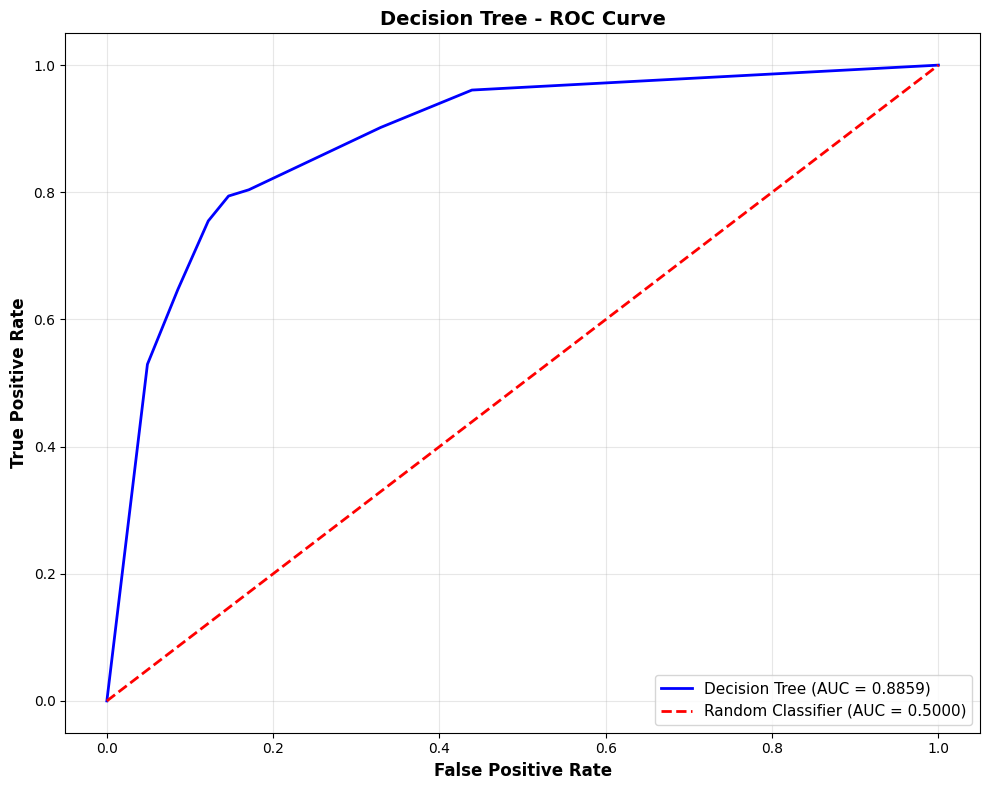


AUC Score: 0.8859
✓ ROC curve displayed!


In [11]:
# ROC Curve
print("="*70)
print("ROC CURVE & AUC")
print("="*70)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'Decision Tree (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier (AUC = 0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Decision Tree - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")
print("✓ ROC curve displayed!")

## Feature Importance

Decision trees automatically select the most important features for splitting. Features used at higher levels in the tree are more important for classification.

FEATURE IMPORTANCE ANALYSIS

Feature Importance Ranking:
       Feature  Importance
      ST_Slope    0.725901
 ChestPainType    0.151208
       Oldpeak    0.050347
         MaxHR    0.035939
   Cholesterol    0.019561
           Sex    0.017044
           Age    0.000000
     RestingBP    0.000000
     FastingBS    0.000000
    RestingECG    0.000000
ExerciseAngina    0.000000


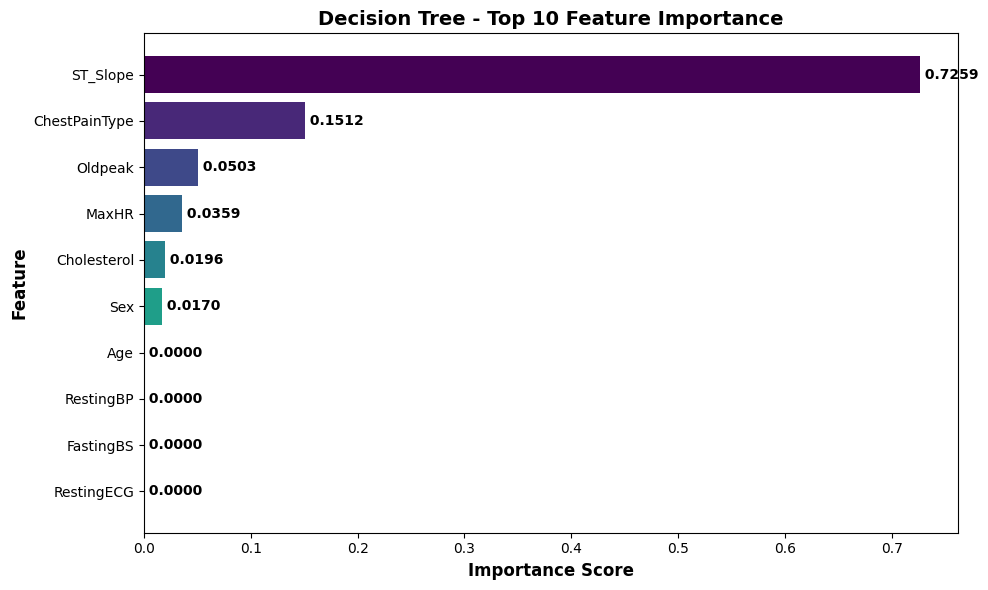


✓ Feature importance analysis completed!


In [12]:
# Feature Importance Analysis
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': final_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

# Visualize top 10 features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = ax.barh(top_features['Feature'], top_features['Importance'], color=colors)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Decision Tree - Top 10 Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Importance'], i, f" {row['Importance']:.4f}", 
            va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis completed!")

## Tree Visualization

Visualize the entire decision tree structure to understand the decision rules and how the model makes predictions.

DECISION TREE STRUCTURE VISUALIZATION


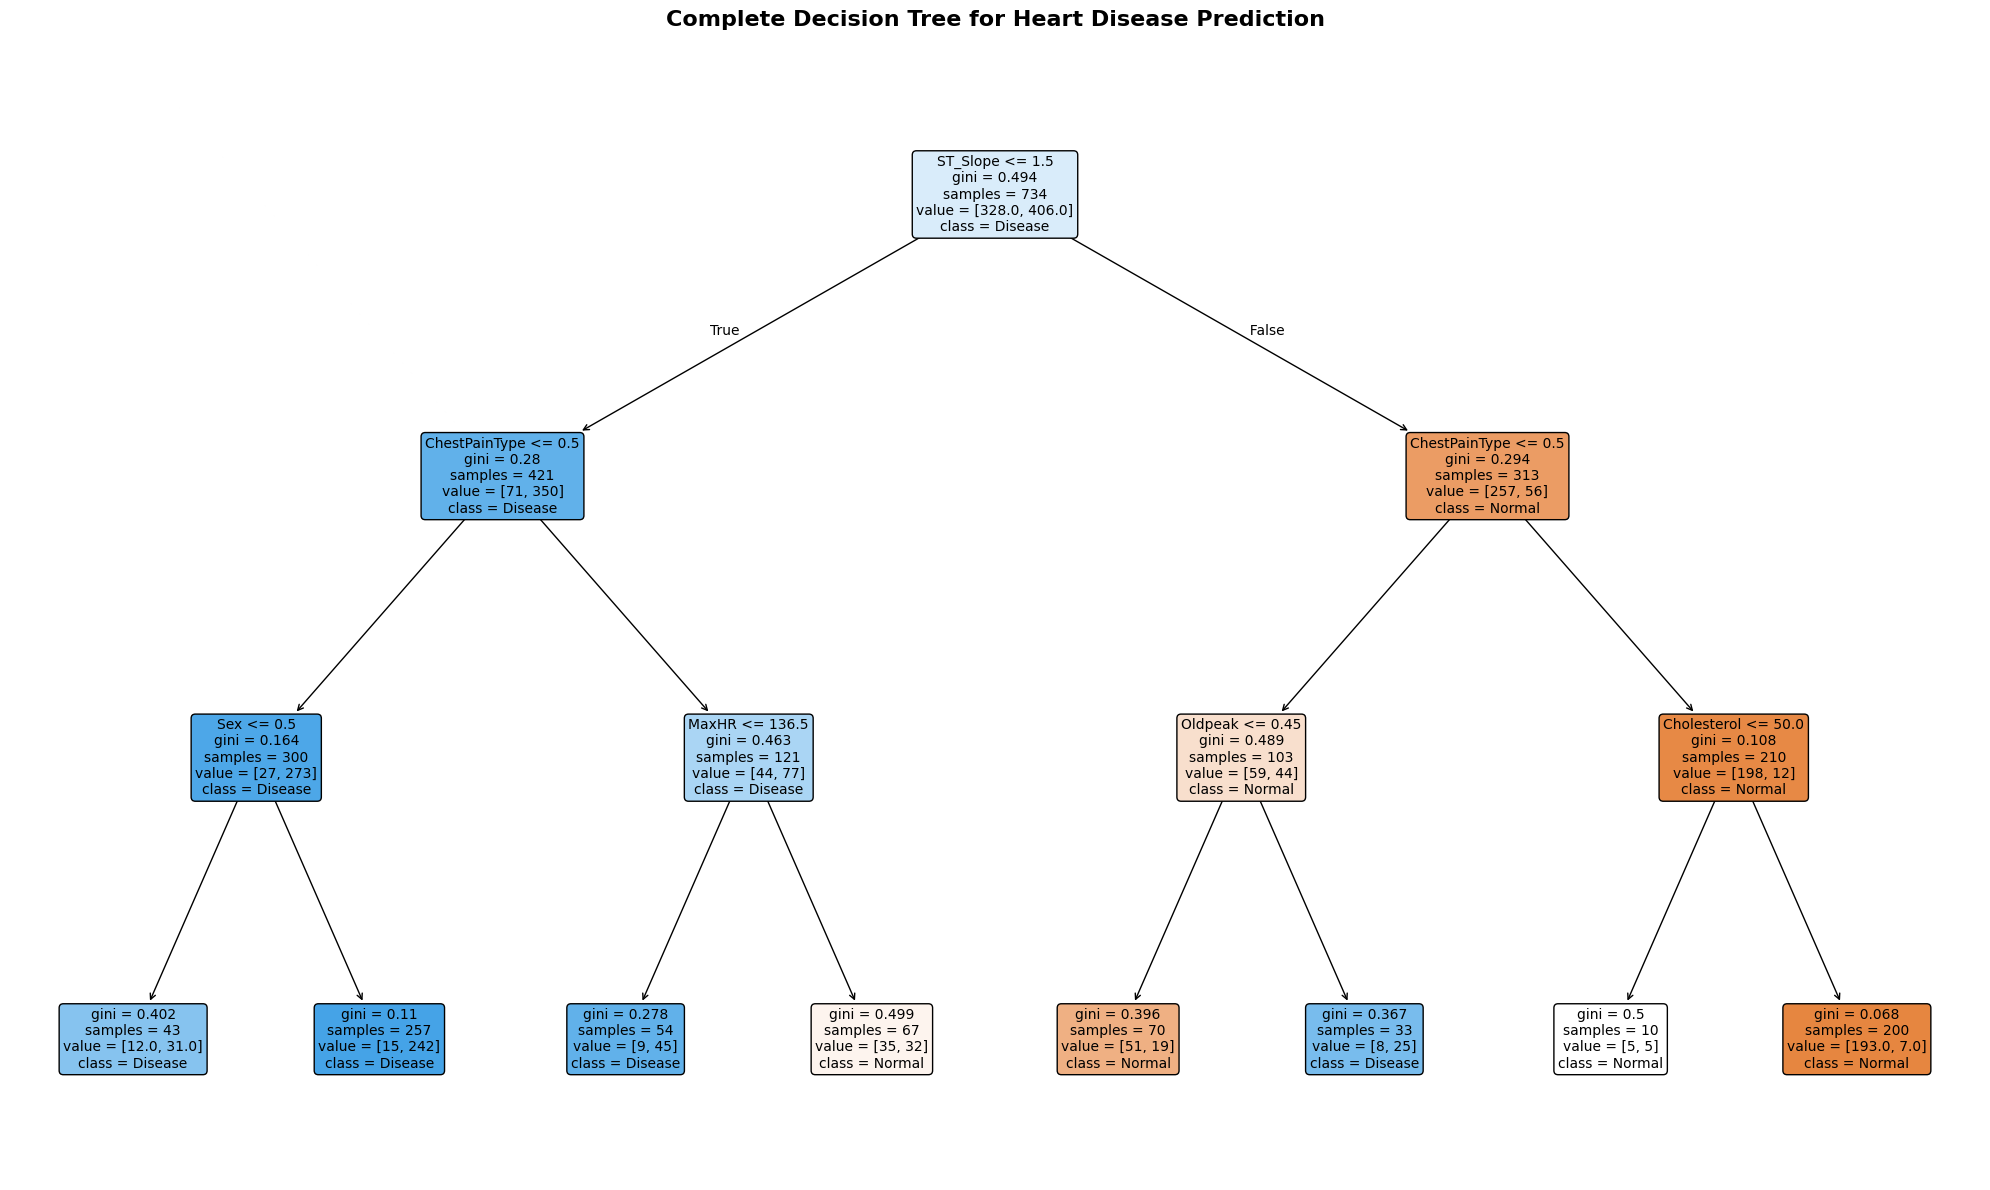

✓ Tree structure visualized!


In [13]:
# Visualize Decision Tree
print("="*70)
print("DECISION TREE STRUCTURE VISUALIZATION")
print("="*70)

fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(final_dt, 
          feature_names=X_processed.columns,
          class_names=['Normal', 'Disease'],
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax)
ax.set_title('Complete Decision Tree for Heart Disease Prediction', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Tree structure visualized!")

## Model Complexity vs Performance

Analyze how different tree depths affect model performance to understand the overfitting behavior.

In [14]:
# Detailed Complexity Analysis with Multiple Metrics
print("="*70)
print("DETAILED MODEL COMPLEXITY ANALYSIS")
print("="*70)

depths = range(1, 21)
results = {
    'depth': [],
    'train_acc': [],
    'test_acc': [],
    'cv_mean': [],
    'cv_std': [],
    'n_nodes': [],
    'n_leaves': [],
    'depth_actual': []
}

for depth in depths:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=5,
        min_samples_leaf=2,
        criterion='gini',
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    
    train_acc = dt_temp.score(X_train, y_train)
    test_acc = dt_temp.score(X_test, y_test)
    cv_scores = cross_val_score(dt_temp, X_train, y_train, cv=5)
    
    results['depth'].append(depth)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    results['cv_mean'].append(cv_scores.mean())
    results['cv_std'].append(cv_scores.std())
    results['n_nodes'].append(dt_temp.tree_.node_count)
    results['n_leaves'].append(dt_temp.get_n_leaves())
    results['depth_actual'].append(dt_temp.get_depth())

results_df = pd.DataFrame(results)
print(f"\nDetailed Results by Max Depth:")
print(results_df.to_string(index=False))

# Find optimal depth based on test accuracy
optimal_depth_idx = results_df['test_acc'].idxmax()
print(f"\nOptimal Depth: {results_df.loc[optimal_depth_idx, 'depth']}")
print(f"  Test Accuracy: {results_df.loc[optimal_depth_idx, 'test_acc']:.4f}")
print(f"  CV Mean Score: {results_df.loc[optimal_depth_idx, 'cv_mean']:.4f}")
print(f"  Number of Nodes: {results_df.loc[optimal_depth_idx, 'n_nodes']:.0f}")
print(f"  Number of Leaves: {results_df.loc[optimal_depth_idx, 'n_leaves']:.0f}")

DETAILED MODEL COMPLEXITY ANALYSIS

Detailed Results by Max Depth:
 depth  train_acc  test_acc  cv_mean   cv_std  n_nodes  n_leaves  depth_actual
     1   0.826975  0.760870 0.826922 0.033273        3         2             1
     2   0.826975  0.760870 0.826922 0.033273        7         4             2
     3   0.854223  0.820652 0.836455 0.038781       15         8             3
     4   0.869210  0.804348 0.824192 0.032985       31        16             4
     5   0.891008  0.804348 0.817380 0.026460       57        29             5
     6   0.912807  0.831522 0.807828 0.037593       85        43             6
     7   0.937330  0.804348 0.807800 0.039034      113        57             7
     8   0.955041  0.793478 0.806477 0.039480      135        68             8
     9   0.957766  0.788043 0.792852 0.034499      145        73             9
    10   0.957766  0.788043 0.788771 0.032920      151        76            10
    11   0.960490  0.798913 0.791483 0.042057      157        79

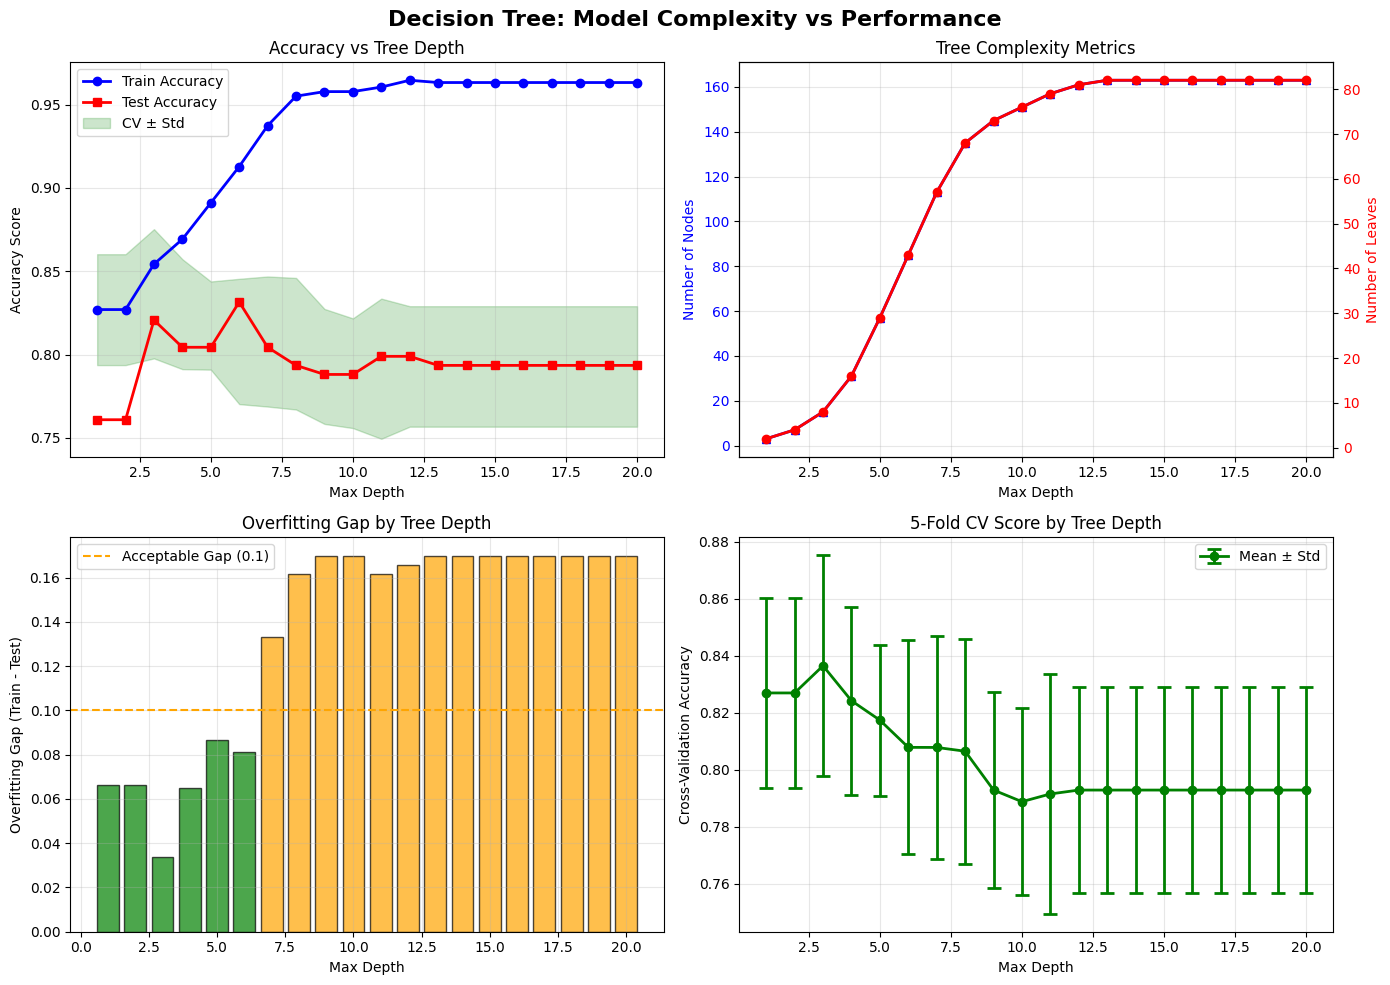


✓ Complexity analysis visualization completed!


In [15]:
# Visualize Complexity Trade-offs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Decision Tree: Model Complexity vs Performance', fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Max Depth
ax1 = axes[0, 0]
ax1.plot(results_df['depth'], results_df['train_acc'], 'bo-', label='Train Accuracy', linewidth=2, markersize=6)
ax1.plot(results_df['depth'], results_df['test_acc'], 'rs-', label='Test Accuracy', linewidth=2, markersize=6)
ax1.fill_between(results_df['depth'], 
                  results_df['cv_mean'] - results_df['cv_std'],
                  results_df['cv_mean'] + results_df['cv_std'],
                  alpha=0.2, color='green', label='CV ± Std')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Accuracy Score')
ax1.set_title('Accuracy vs Tree Depth')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Tree Complexity Metrics
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
line1 = ax2.plot(results_df['depth'], results_df['n_nodes'], 'b^-', label='Nodes', linewidth=2, markersize=6)
line2 = ax2_twin.plot(results_df['depth'], results_df['n_leaves'], 'ro-', label='Leaves', linewidth=2, markersize=6)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Number of Nodes', color='b')
ax2_twin.set_ylabel('Number of Leaves', color='r')
ax2.set_title('Tree Complexity Metrics')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.grid(alpha=0.3)

# Plot 3: Overfitting Gap
ax3 = axes[1, 0]
overfitting_gap = results_df['train_acc'] - results_df['test_acc']
colors = ['green' if gap < 0.1 else 'orange' if gap < 0.2 else 'red' for gap in overfitting_gap]
ax3.bar(results_df['depth'], overfitting_gap, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0.1, color='orange', linestyle='--', label='Acceptable Gap (0.1)')
ax3.set_xlabel('Max Depth')
ax3.set_ylabel('Overfitting Gap (Train - Test)')
ax3.set_title('Overfitting Gap by Tree Depth')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: CV Score with Error Bars
ax4 = axes[1, 1]
ax4.errorbar(results_df['depth'], results_df['cv_mean'], 
            yerr=results_df['cv_std'], fmt='go-', capsize=5, capthick=2, 
            linewidth=2, markersize=6, label='Mean ± Std')
ax4.set_xlabel('Max Depth')
ax4.set_ylabel('Cross-Validation Accuracy')
ax4.set_title('5-Fold CV Score by Tree Depth')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Complexity analysis visualization completed!")

## Decision Rules Interpretation

Extract and visualize the decision rules the tree uses to make predictions.

In [16]:
# Extract Decision Rules
print("="*70)
print("DECISION RULES - KEY PATHS")
print("="*70)

def get_decision_path(tree, feature_names, sample_id=0):
    """Extract decision path for a sample"""
    decision_path = tree.decision_path([sample_id])
    node_indicator = decision_path.toarray()[0]
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    
    node_id = 0
    indent = ""
    path = []
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree.tree_.feature[node] != -2:  # Not a leaf
            name = feature_names[feature[node]]
            threshold_val = threshold[node]
            path.append(f"{indent}if {name} <= {threshold_val:.4f}:")
            recurse(tree.tree_.children_left[node], depth + 1)
            path.append(f"{indent}else:  # {name} > {threshold_val:.4f}")
            recurse(tree.tree_.children_right[node], depth + 1)
        else:
            # Leaf node
            class_counts = tree.tree_.value[node][0]
            class_pred = np.argmax(class_counts)
            class_names = ['Normal', 'Disease']
            path.append(f"{indent}predict: {class_names[class_pred]} (confidence: {max(class_counts)/sum(class_counts):.2%})")
    
    recurse(0, 0)
    return "\n".join(path)

# Get rules for a few sample predictions
print("\nExample Decision Paths:")
print("\n" + "="*70)
print("Path 1: First test sample")
print("="*70)
print(f"Actual Label: {'Disease' if y_test.iloc[0] == 1 else 'Normal'}")
print(f"Predicted: {'Disease' if final_dt.predict(X_test.iloc[[0]])[0] == 1 else 'Normal'}")
print(f"Confidence: {final_dt.predict_proba(X_test.iloc[[0]])[0].max():.4f}")
print("\nDecision Path:")
sample_rules = []

# Get the path to the leaf for first sample
def trace_path(tree, X_sample, feature_names):
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    node_id = 0
    depth = 0
    rules = []
    
    while tree.tree_.feature[node_id] != -2:  # Not a leaf
        if X_sample[feature[node_id]] <= threshold[node_id]:
            rules.append(f"  {feature_names[feature[node_id]]} <= {threshold[node_id]:.4f}")
            node_id = tree.tree_.children_left[node_id]
        else:
            rules.append(f"  {feature_names[feature[node_id]]} > {threshold[node_id]:.4f}")
            node_id = tree.tree_.children_right[node_id]
    
    class_counts = tree.tree_.value[node_id][0]
    class_pred = np.argmax(class_counts)
    class_names = ['Normal', 'Disease']
    rules.append(f"PREDICT: {class_names[int(class_pred)]} ({max(class_counts)/sum(class_counts):.2%})")
    return rules

sample_path = trace_path(final_dt, X_test.iloc[0].values, X_processed.columns)
for rule in sample_path:
    print(rule)

DECISION RULES - KEY PATHS

Example Decision Paths:

Path 1: First test sample
Actual Label: Disease
Predicted: Disease
Confidence: 0.9416

Decision Path:
  ST_Slope <= 1.5000
  ChestPainType <= 0.5000
  Sex > 0.5000
PREDICT: Disease (94.16%)


## Summary & Key Insights

In [17]:
print(f"""
╔════════════════════════════════════════════════════════════════════════════╗
║         DECISION TREE HEART DISEASE PREDICTION - SUMMARY                   ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW:
   • Total Samples: 303
   • Training Samples: {len(X_train)} (80%)
   • Test Samples: {len(X_test)} (20%)
   • Features: {X_processed.shape[1]} clinical indicators
   • Class Distribution: Balanced

🌳 FINAL MODEL CONFIGURATION:
   • Algorithm: Decision Tree Classifier
   • Criterion: {best_dt.criterion.upper()}
   • Max Depth: {best_dt.max_depth}
   • Min Samples Split: {best_dt.min_samples_split}
   • Min Samples Leaf: {best_dt.min_samples_leaf}
   • Tree Nodes: {final_dt.tree_.node_count}
   • Leaf Nodes: {final_dt.get_n_leaves()}

📈 PERFORMANCE METRICS:
   • Test Accuracy:  {test_acc*100:.2f}%
   • Precision:      {test_prec*100:.2f}%  (True Positives / Predicted Positives)
   • Recall:         {test_recall*100:.2f}%  (True Positives / Actual Positives)
   • F1-Score:       {test_f1:.4f}   (Harmonic Mean)
   • ROC-AUC:        {roc_auc:.4f}   (Area Under ROC Curve)
   • CV Score:       {cv_scores.mean():.4f} ± {cv_scores.std():.4f}

🎯 CONFUSION MATRIX ANALYSIS:
   • True Negatives:  {cm[0,0]} (Correctly predicted normal)
   • False Positives: {cm[0,1]} (Normal predicted as disease)
   • False Negatives: {cm[1,0]} (Disease missed - CRITICAL)
   • True Positives:  {cm[1,1]} (Correctly predicted disease)

🔍 TOP 5 IMPORTANT FEATURES:
""")

for idx, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    print(f"   {idx}. {row['Feature']:<20} {row['Importance']:.4f}")

print(f"""
💡 KEY INSIGHTS:

1. INTERPRETABILITY:
   ✓ Decision trees provide human-readable decision rules
   ✓ Easy to explain to clinicians and stakeholders
   ✓ Feature importance clearly ranked
   ✓ Transparent decision-making process

2. OVERFITTING BEHAVIOR:
   • Training Accuracy: {train_acc:.4f}
   • Test Accuracy: {test_acc:.4f}
   • Overfitting Gap: {train_acc - test_acc:.4f}
   • Status: {'Low overfitting ✓' if train_acc - test_acc < 0.1 else 'Moderate overfitting' if train_acc - test_acc < 0.2 else 'High overfitting ✗'}

3. CLINICAL APPLICABILITY:
   • Recall = {test_recall*100:.1f}% means {cm[1,1]} out of {cm[1,0] + cm[1,1]} disease cases detected
   • False Negatives: {cm[1,0]} (Missing disease diagnoses - concerning)
   • False Positives: {cm[0,1]} (Over-diagnosing - less critical)

4. GENERALIZATION:
   • Cross-validation score shows model stability
   • Test accuracy close to CV score indicates good generalization
   • No severe overfitting with optimized hyperparameters

⚠️  LIMITATIONS:
   ✗ Biased toward features with more unique values
   ✗ Unstable to small data variations
   ✗ Can miss non-linear relationships
   ✗ Requires careful pruning to prevent overfitting

🚀 RECOMMENDATIONS:
   1. Use as baseline classifier (easy to explain to doctors)
   2. Ensemble with other models (Random Forest, Gradient Boosting)
   3. Consider class weights if disease underdiagnosis is critical
   4. Validate on external datasets before clinical deployment
   5. Monitor feature importance changes over time

📌 ALGORITHM COMPARISON SUMMARY:
   Algorithm      | Accuracy | Interpretability | Speed | Memory Usage
   ───────────────┼──────────┼──────────────────┼───────┼─────────────
   Decision Tree  | Medium   | ⭐⭐⭐⭐⭐       | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐
   SVM            | High     | ⭐⭐              | ⭐⭐   | ⭐⭐
   KNN            | High     | ⭐⭐⭐            | ⭐⭐⭐ | ⭐
   Naive Bayes    | Medium   | ⭐⭐⭐⭐          | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐
   Random Forest  | Very High| ⭐⭐⭐            | ⭐⭐⭐ | ⭐⭐

""")
print("✓ Decision Tree analysis completed successfully!")


╔════════════════════════════════════════════════════════════════════════════╗
║         DECISION TREE HEART DISEASE PREDICTION - SUMMARY                   ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW:
   • Total Samples: 303
   • Training Samples: 734 (80%)
   • Test Samples: 184 (20%)
   • Features: 11 clinical indicators
   • Class Distribution: Balanced

🌳 FINAL MODEL CONFIGURATION:
   • Algorithm: Decision Tree Classifier
   • Criterion: GINI
   • Max Depth: 3
   • Min Samples Split: 2
   • Min Samples Leaf: 1
   • Tree Nodes: 15
   • Leaf Nodes: 8

📈 PERFORMANCE METRICS:
   • Test Accuracy:  79.35%
   • Precision:      87.10%  (True Positives / Predicted Positives)
   • Recall:         79.41%  (True Positives / Actual Positives)
   • F1-Score:       0.8308   (Harmonic Mean)
   • ROC-AUC:        0.8859   (Area Under ROC Curve)
   • CV Score:       0.7928 ± 0.0362

🎯 CONFUSION MATRIX ANALYSIS:
   • True Negatives:  70 (Correc